# Trexquant Interview Project (The Hangman Game)

* Copyright Trexquant Investment LP. All Rights Reserved. 
* Redistribution of this question without written consent from Trexquant is prohibited

## Instruction:
For this coding test, your mission is to write an algorithm that plays the game of Hangman through our API server. 

When a user plays Hangman, the server first selects a secret word at random from a list. The server then returns a row of underscores (space separated)—one for each letter in the secret word—and asks the user to guess a letter. If the user guesses a letter that is in the word, the word is redisplayed with all instances of that letter shown in the correct positions, along with any letters correctly guessed on previous turns. If the letter does not appear in the word, the user is charged with an incorrect guess. The user keeps guessing letters until either (1) the user has correctly guessed all the letters in the word
or (2) the user has made six incorrect guesses.

You are required to write a "guess" function that takes current word (with underscores) as input and returns a guess letter. You will use the API codes below to play 1,000 Hangman games. You have the opportunity to practice before you want to start recording your game results.

Your algorithm is permitted to use a training set of approximately 250,000 dictionary words. Your algorithm will be tested on an entirely disjoint set of 250,000 dictionary words. Please note that this means the words that you will ultimately be tested on do NOT appear in the dictionary that you are given. You are not permitted to use any dictionary other than the training dictionary we provided. This requirement will be strictly enforced by code review.

You are provided with a basic, working algorithm. This algorithm will match the provided masked string (e.g. a _ _ l e) to all possible words in the dictionary, tabulate the frequency of letters appearing in these possible words, and then guess the letter with the highest frequency of appearence that has not already been guessed. If there are no remaining words that match then it will default back to the character frequency distribution of the entire dictionary.

This benchmark strategy is successful approximately 18% of the time. Your task is to design an algorithm that significantly outperforms this benchmark.

In [119]:
import json
import requests
import random
import string
import secrets
import time
import re
import collections
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

try:
    from urllib.parse import parse_qs, urlencode, urlparse
except ImportError:
    from urlparse import parse_qs, urlparse
    from urllib import urlencode

from requests.packages.urllib3.exceptions import InsecureRequestWarning
requests.packages.urllib3.disable_warnings(InsecureRequestWarning)

In [424]:
class HangmanAPI(object):
    def __init__(self, model, word_list, max_len, access_token=None, session=None, timeout=None):
        self.hangman_url = self.determine_hangman_url()
        self.access_token = access_token
        self.session = session or requests.Session()
        self.timeout = timeout
        self.guessed_letters = []
        
        full_dictionary_location = "words_250000_train.txt"
        self.full_dictionary = self.build_dictionary(full_dictionary_location)        
        self.full_dictionary_common_letter_sorted = collections.Counter("".join(self.full_dictionary)).most_common()
        self.current_dictionary = []

        #### added parameters
        self.model = model # model to play the guess 
        self.word_list = word_list # a list including all training data
        self.max_len = max_len # maximum len of words 
        alphabet = list(chr(i) for i in range(ord('a'), ord('z')+1))
        self.vocab = ['Pad'] + alphabet + ['_']
        self.char2idx = {ch: i for i, ch in enumerate(self.vocab)} # map: ordinal encoder of letters (and padding)
        self.letter_to_idx = {letter: idx for idx, letter in enumerate(alphabet)}

        self.results = []
        self.word_len = []
    @staticmethod
    def determine_hangman_url():
        links = ['https://trexsim.com']

        data = {link: 0 for link in links}

        for link in links:

            requests.get(link)

            for i in range(10):
                s = time.time()
                requests.get(link)
                data[link] = time.time() - s

        link = sorted(data.items(), key=lambda x: x[1])[0][0]
        link += '/trexsim/hangman'
        return link
    
    def encode_word(self, masked_word):
        # ordinal encoder of masked word
        input_str = masked_word
        input_ids = [self.char2idx[c] for c in input_str]
        # pad if shorter than max_len: make sure fixed length sequence
        if len(input_ids) < self.max_len:
            input_ids += [self.char2idx['Pad']] * (self.max_len - len(input_ids))
        else:
            # trancate if longer than max length
            input_ids = input_ids[:self.max_len]

        return input_ids

    def encode_guessed_letters(self, guessed_letters):
        target_vec = [0] * 26  # only 'a' to 'z'
        for c in guessed_letters:
            target_vec[ord(c) - ord('a')] = 1
            
        return target_vec
    
    def encode_data(self, masked_word, guessed_letters):
        input_words = self.encode_word(masked_word)
        guessed_letters = self.encode_guessed_letters(guessed_letters)

        return input_words, guessed_letters
    

    # probability of words after screening out 
    def prob_screening(self, guessed_wrong_letters, guessed_correct_letters, word_length):
        guessed_wrong_set = set(guessed_wrong_letters)
        guessed_correct_letters = set(guessed_correct_letters)
        # Filter words
        possible_words = [
            word for word in self.word_list
            if len(word) == word_length and guessed_wrong_set.isdisjoint(word) and guessed_correct_letters.issubset(word)
            #if guessed_wrong_set.isdisjoint(word) and guessed_correct_letters.issubset(word)
        ]
        # Initialize probability array
        prob = [0] * 26
        for word in possible_words:
            for letter in set(word):  # avoid double-counting letters
                prob[self.letter_to_idx[letter]] += 1
        n = max(len(possible_words), 1)  # avoid division by zero
        epsilon = 0.0001
        prob = [p/n + epsilon for p in prob]
        return len(possible_words), np.array(prob)

    def guess(self, word, tries_remains): # word input example: "_ p p _ e "
        ###############################################
        # Replace with your own "guess" function here #
        ###############################################
        # remove space and make sure lower cases
        word = word.replace(" ", "").lower()
        # if letters in word, then put them in guesses_letters as well
        correct_letters = list(set(word))
        correct_letters.remove('_')
        guessed_letters = self.guessed_letters + [letters for letters in word if letters != '_' and letters not in self.guessed_letters]
        wrong_letters = [c for c in guessed_letters if c not in correct_letters]
        word_len = len(word)
        if word_len > self.max_len:
            word_len = self.max_len

        #unknown_number = word.count('_')
        #unknown_ratio = unknown_number / word_len
        #print('correct_letters:', correct_letters)
        #print('wrong_letters:', wrong_letters)
        #print('guessed_letters:', guessed_letters)
        
        known_number = len(set(word)) - 1  # minus '_'
        if known_number < 3:
            print('Early Stage of the game')
            # start stage: strategic rules for the first two letters
            _, prob_vector = self.prob_screening(wrong_letters, correct_letters, word_len)  # shape (26,)
            # sort letters by descending probability
            sorted_indices = np.argsort(prob_vector)[::-1]
            for idx in sorted_indices:
                if chr(ord('a') + idx) not in guessed_letters: 
                    return chr(ord('a') + idx)
        else:
            # enter the mid and late stage of the game
            len_dict, uncon_prob = self.prob_screening(wrong_letters, correct_letters, word_len)          
            # encode data
            word, guessed_letters = self.encode_data(word, guessed_letters)
            word = np.array(word).reshape(1,-1)
            #guessed_letters = np.array(guessed_letters).reshape(1,-1)
            word_len = np.array(word_len).reshape(1,-1)
            probs = self.model.predict([word, word_len], verbose=0)[0]  # shape (26,)
            if len_dict > 200 and tries_remains > 2:
                print('Mid Stage of the game')
                # mid stage of the game: model prediction combines with the strategic rules 
                probs = uncon_prob*probs
            else:
                print('Late Stage of the game')

            # else: late stage of the game
            # convert guessed letters from binary to a boolean mask
            guessed_mask = np.array(guessed_letters).astype(bool)
            # set the probabilities of already guessed letters to -1 to ignore them
            probs[guessed_mask] = -1
            # pick the index (letter) with the highest remaining probability
            next_letter_index_probs = np.argmax(probs)
            next_letter = string.ascii_lowercase[next_letter_index_probs]

            return next_letter

    ##########################################################
    # You'll likely not need to modify any of the code below #
    ##########################################################
    
    def build_dictionary(self, dictionary_file_location):
        text_file = open(dictionary_file_location,"r")
        full_dictionary = text_file.read().splitlines()
        text_file.close()
        return full_dictionary
                
    def start_game(self, practice=True, verbose=True):
        # reset guessed letters to empty set and current plausible dictionary to the full dictionary
        self.guessed_letters = []
        self.current_dictionary = self.full_dictionary
                         
        response = self.request("/new_game", {"practice":practice})
        if response.get('status')=="approved":
            game_id = response.get('game_id')
            word = response.get('word')
            self.word_len.append(len(word.replace(" ", "").lower()))
            tries_remains = response.get('tries_remains')
            if verbose:
                print("Successfully start a new game! Game ID: {0}. # of tries remaining: {1}. Word: {2}.".format(game_id, tries_remains, word))
            while tries_remains>0:
                # get guessed letter from user code
                guess_letter = self.guess(word, tries_remains)
                    
                # append guessed letter to guessed letters field in hangman object
                self.guessed_letters.append(guess_letter)
                if verbose:
                    print("Guessing letter: {0}".format(guess_letter))
                    
                try:    
                    res = self.request("/guess_letter", {"request":"guess_letter", "game_id":game_id, "letter":guess_letter})
                except HangmanAPIError:
                    print('HangmanAPIError exception caught on request.')
                    continue
                except Exception as e:
                    print('Other exception caught on request.')
                    raise e
               
                if verbose:
                    print("Sever response: {0}".format(res))
                status = res.get('status')
                tries_remains = res.get('tries_remains')
                if status=="success":
                    self.results.append(1)
                    if verbose:
                        print("Successfully finished game: {0}".format(game_id))
                    return True
                elif status=="failed":
                    self.results.append(0)
                    reason = res.get('reason', '# of tries exceeded!')
                    if verbose:
                        print("Failed game: {0}. Because of: {1}".format(game_id, reason))
                    return False
                elif status=="ongoing":
                    word = res.get('word')
        else:
            if verbose:
                print("Failed to start a new game")
        
        return status=="success"
        
    def my_status(self):
        return self.request("/my_status", {})
    
    def request(
            self, path, args=None, post_args=None, method=None):
        if args is None:
            args = dict()
        if post_args is not None:
            method = "POST"

        # Add `access_token` to post_args or args if it has not already been
        # included.
        if self.access_token:
            # If post_args exists, we assume that args either does not exists
            # or it does not need `access_token`.
            if post_args and "access_token" not in post_args:
                post_args["access_token"] = self.access_token
            elif "access_token" not in args:
                args["access_token"] = self.access_token

        time.sleep(0.2)

        num_retry, time_sleep = 50, 2
        for it in range(num_retry):
            try:
                response = self.session.request(
                    method or "GET",
                    self.hangman_url + path,
                    timeout=self.timeout,
                    params=args,
                    data=post_args,
                    verify=False
                )
                break
            except requests.HTTPError as e:
                response = json.loads(e.read())
                raise HangmanAPIError(response)
            except requests.exceptions.SSLError as e:
                if it + 1 == num_retry:
                    raise
                time.sleep(time_sleep)

        headers = response.headers
        if 'json' in headers['content-type']:
            result = response.json()
        elif "access_token" in parse_qs(response.text):
            query_str = parse_qs(response.text)
            if "access_token" in query_str:
                result = {"access_token": query_str["access_token"][0]}
                if "expires" in query_str:
                    result["expires"] = query_str["expires"][0]
            else:
                raise HangmanAPIError(response.json())
        else:
            raise HangmanAPIError('Maintype was not text, or querystring')

        if result and isinstance(result, dict) and result.get("error"):
            raise HangmanAPIError(result)
        return result
    
class HangmanAPIError(Exception):
    def __init__(self, result):
        self.result = result
        self.code = None
        try:
            self.type = result["error_code"]
        except (KeyError, TypeError):
            self.type = ""

        try:
            self.message = result["error_description"]
        except (KeyError, TypeError):
            try:
                self.message = result["error"]["message"]
                self.code = result["error"].get("code")
                if not self.type:
                    self.type = result["error"].get("type", "")
            except (KeyError, TypeError):
                try:
                    self.message = result["error_msg"]
                except (KeyError, TypeError):
                    self.message = result

        Exception.__init__(self, self.message)

# Data Prepration

In [3]:
# read training data
with open("words_250000_train.txt", "r") as f:
    word_list = [line.strip().lower() for line in f if line.strip().isalpha()]

In [4]:
max_word_length = max(len(word) for word in word_list)
print('max_word_length:', max_word_length)

max_word_length: 29


In [5]:
# distribution of word_list
alphabet = string.ascii_lowercase

# initialize counts and word length counters
distribution = np.zeros((max_word_length, 26))
word_length_count = [0]*max_word_length

for word in word_list:
    word_len = len(word)
    word_length_count[word_len-1] += 1
    unique_letters = set(word)
    for letter in unique_letters:
        col = ord(letter) - ord('a')
        distribution[word_len - 1][col] += 1  # row index is word_len - 1

word_length_count = np.array(word_length_count)
word_length_count = word_length_count.reshape(-1,1)
distribution = np.divide(distribution, word_length_count)

C:\Users\yijin\AppData\Local\Temp\ipykernel_38112\382915921.py:18: RuntimeWarning: invalid value encountered in divide
  distribution = np.divide(distribution, word_length_count)


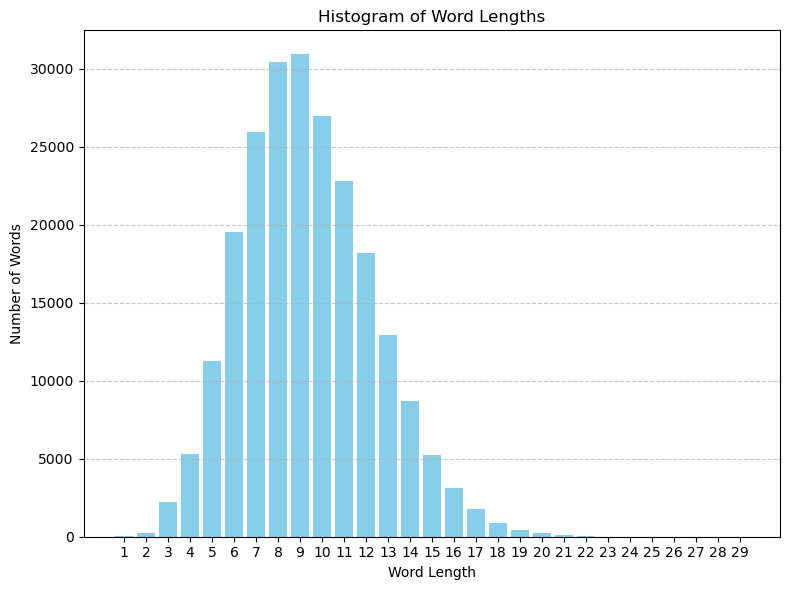

In [6]:
x = list(range(1, len(word_length_count) + 1))
plt.figure(figsize=(8, 6))
plt.bar(x, word_length_count.reshape(-1), color='skyblue')
plt.xlabel("Word Length")
plt.ylabel("Number of Words")
plt.title("Histogram of Word Lengths")
plt.xticks(x)  # Ensure each word length shows up on the x-axis
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

[]

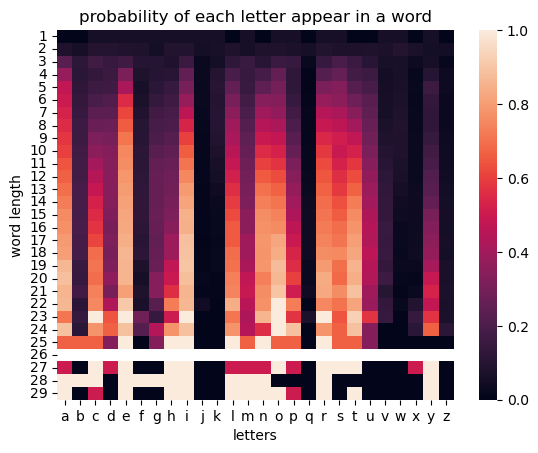

In [7]:
sns.heatmap(distribution, xticklabels=alphabet, yticklabels=range(1, 30))
plt.xlabel('letters')
plt.ylabel('word length')
plt.title('probability of each letter appear in a word')
plt.plot()

In [8]:
distribution.shape

(29, 26)

In [9]:
### conditional distribution
max_word_length = 20
letter_to_idx = {letter: idx for idx, letter in enumerate(alphabet)}
# counts: [word_length][given_letter][other_letter]
counts = np.zeros((max_word_length, 26, 26))  # we will zero out the diagonal later
condition_counts = np.zeros((max_word_length, 26))  # how many words of this length contain letter i
for word in word_list:
    word = word.lower().strip()
    n = len(word)
    if not word.isalpha() or n > max_word_length:
        continue

    unique_letters = set(word)
    indices = [letter_to_idx[c] for c in unique_letters]
    for i in indices:
        for j in indices:
            counts[n-1][i][j] += 1
        condition_counts[n-1][i] += 1
    
# remove the diagonal (we want distribution of OTHER letters)
for i in range(max_word_length):
    np.fill_diagonal(counts[i], 0)

# Normalize
cond_dist = np.zeros_like(counts)
for L in range(max_word_length):
    for i in range(26):
        if condition_counts[L][i] > 0:
            cond_dist[L][i] = counts[L][i] / condition_counts[L][i]

[]

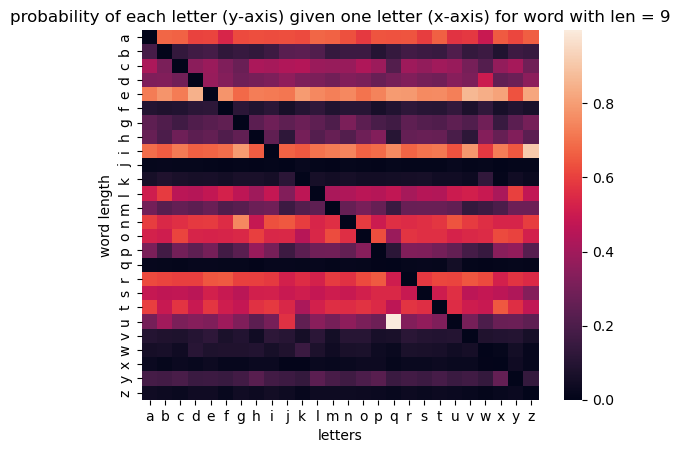

In [10]:
plot_example = np.array(cond_dist[10].T)
sns.heatmap(plot_example, xticklabels=alphabet, yticklabels=alphabet)
plt.xlabel('letters')
plt.ylabel('word length')
plt.title('probability of each letter (y-axis) given one letter (x-axis) for word with len = 9')
plt.plot()

In [11]:
cond_dist[9][0]

array([0.        , 0.18405627, 0.36780404, 0.32350219, 0.70858271,
       0.09452706, 0.21854754, 0.24662183, 0.62571728, 0.01295736,
       0.07385698, 0.47862035, 0.27321528, 0.54297526, 0.45807367,
       0.25353242, 0.01733819, 0.57573888, 0.45406306, 0.5443944 ,
       0.27500463, 0.08817178, 0.06959956, 0.0283211 , 0.15986919,
       0.03473808])

In [12]:
np.argmax(cond_dist[9][0])

4

In [13]:
# probability of words after screening out 
def prob_screening(guessed_wrong_letters, guessed_correct_letters, word_length):
    guessed_wrong_set = set(guessed_wrong_letters)
    guessed_correct_letters = set(guessed_correct_letters)
    # Filter words
    possible_words = [
        word for word in word_list
        if len(word) == word_length and guessed_wrong_set.isdisjoint(word) and guessed_correct_letters.issubset(word)
    ]
    # Initialize probability array
    prob = [0] * 26
    for word in possible_words:
        for letter in set(word):  # avoid double-counting letters
            if letter not in guessed_correct_letters:
                prob[letter_to_idx[letter]] += 1
    n = len(possible_words) or 1  # avoid division by zero
    epsilon = 0.0001
    prob = [p / n + epsilon for p in prob]
    return possible_words, prob


In [14]:
possible_words, prob = prob_screening(['j','i','h'], ['a'], 9)

In [15]:
possible_words

['aasvogels',
 'abamperes',
 'abandoned',
 'abandonee',
 'abbottson',
 'abductors',
 'abecedary',
 'abelmosks',
 'aberrance',
 'aberrancy',
 'abetments',
 'abeyances',
 'ablactate',
 'ablegates',
 'abnegated',
 'abnegator',
 'abnormous',
 'aboardage',
 'abococket',
 'abodement',
 'abortuses',
 'abrogable',
 'abrogated',
 'abrogator',
 'absampere',
 'abscessed',
 'absconder',
 'absentees',
 'absoluter',
 'absorbent',
 'absterged',
 'absterges',
 'absurdest',
 'abutments',
 'acapsular',
 'accentual',
 'acceptors',
 'accessary',
 'accessory',
 'accoladed',
 'accolated',
 'accordant',
 'accounter',
 'accouters',
 'accoutred',
 'accruable',
 'accumbent',
 'accusable',
 'accusator',
 'accustoms',
 'aceldamas',
 'acentrous',
 'aceraceae',
 'acerbates',
 'acervulus',
 'acescence',
 'acesodyne',
 'acetabula',
 'acetylate',
 'acoemetae',
 'acoumeter',
 'acousmata',
 'acquereur',
 'acrestaff',
 'acrobates',
 'acroblast',
 'acrodrome',
 'acrometer',
 'acrosarca',
 'acrospore',
 'acrylates',
 'actu

In [16]:
prob

[0.0001,
 0.22536063920697316,
 0.30773971970603314,
 0.3422637326952658,
 0.7844103742949923,
 0.10709025807554265,
 0.17289097590155528,
 0.0001,
 0.0001,
 0.0001,
 0.1069193471201504,
 0.4639523329345411,
 0.2509972825158093,
 0.4366065800717826,
 0.4889053324218082,
 0.23441891984276192,
 0.017874739360793025,
 0.6375978636130576,
 0.5005272773884806,
 0.49283628439582977,
 0.3070560758844642,
 0.08094088190052982,
 0.1043556827892668,
 0.025907554264228336,
 0.1628072295334131,
 0.02095113655785336]

<Axes: >

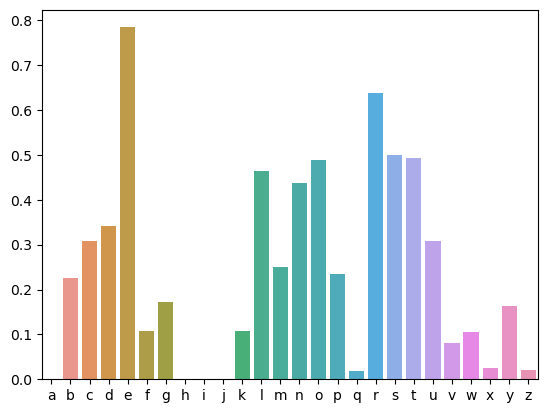

In [17]:
letters = np.array([chr(i) for i in range(ord('a'), ord('z') + 1)])
sns.barplot(x=letters, y=prob)

In [ ]:
# split training and testing words
np.random.permutation(word_list)

In [18]:
from itertools import combinations

In [19]:
def make_masked_word(word, guessed):
    return ''.join([c if c in guessed else '_' for c in word])

In [20]:
idx_to_letter = {idx:letter for idx, letter in enumerate(alphabet)}

In [21]:
distribution.shape

(29, 26)

In [22]:
def naive_method(word):
    wrong_guess = []
    correct_guess = []
    n = len(word)
    word_set = set(word)
    if len(word_set) <= 2:
        return [], list(word_set), []

    while len(correct_guess) < 2:
        #_, prob = prob_screening(wrong_guess, correct_guess, n)
        #predict = idx_to_letter[np.argmax(prob)]
        prob = distribution[n-1]
        prob = np.argsort(prob)[::-1]
        for i in prob:
            predict = idx_to_letter[i]
            if predict in wrong_guess or predict in correct_guess:
                continue
            else:
                # not guessed before
                if predict in word_set:
                    correct_guess.append(predict)
                    word_set.remove(predict)
                else:
                    wrong_guess.append(predict)
                break

    return list(word_set), correct_guess, wrong_guess

In [23]:
naive_method('aaaa')

([], ['a'], [])

In [ ]:
def create_training_examples(word):
    # generate training samples for a given word
    # print(word)
    if len(set(word)) <= 2:
        return []
    examples = []
    # filter out two letters using the naive method
    unique_letters, correct_letters, _ = naive_method(word)
    n = len(unique_letters)
    if n == 0:
        return []
    
    for k in range(n):
        # k: number of guessed letters
        combinations_list = [list(x) for x in combinations(unique_letters, k)]
        # up-sample training samples with larger k: number of guessed letters
        # intuition: it is easier to start guessing but it is harder to guess the last one or two letters
        #if len(combinations_list) < 2*k:
        #    size = len(combinations_list)
        #else:
        #    size = 2*k
        size = k
        #if k == n-2:
        #    size = 2*k # more samples for 2 targets?

        selected_index = np.random.choice([i for i in range(len(combinations_list))], size=size, replace=False)
        
        selected_list = [combinations_list[i] for i in selected_index]
        
        for comb in selected_list:
            #print(comb)
            masked = make_masked_word(word, comb + correct_letters)
            remaining_letters = [c for c in unique_letters if c not in comb]
            #guessed = [chr(c) for c in range(ord('a'), ord('a') + 26) if c not in comb and c not in remaining_letters]
            #guessed_size = np.random.choice([i for i in range(6)], size = 1)
            #guessed = np.random.choice(guessed, size=guessed_size, replace=False)
            guessed = list(correct_letters) + list(comb)            
            examples.append({
                "masked_word": masked,
                "guessed_letters": ''.join(guessed),
                "target": ''.join(remaining_letters)  # multiple correct letters
            })

    return examples

In [339]:
max_word_length = 20
all_examples = [[] for _ in range(max_word_length)]
num_examples = [0]*max_word_length

def process_dictionary(word_list, output_file, num_samples = 10000): 
    if num_samples < len(word_list):
        slected_word_list = np.random.choice(word_list, size=num_samples)
    else:
        slected_word_list = word_list
    i = 0
    for word in slected_word_list:
        n = len(word)
        if not word.isalpha() or n > max_word_length:
            # skip word longer than max_word_length
            continue
        word = word.lower().strip()
        examples = create_training_examples(word)
        if examples != []:
            all_examples[n-1].extend(examples)
        i += 1

    # re-distribute training samples: so that the proportion of 
    # given length of words in trainin data would be equal to that of the whole data
    probabilities = word_length_count[:max_word_length]/np.sum(word_length_count[:max_word_length])
    samples_per_length = np.int32(num_samples * probabilities)
    for i in range(len(all_examples)):
        if len(all_examples[i]) > samples_per_length[i]:
            all_examples[i] = np.random.choice(all_examples[i], size=samples_per_length[i], replace=False)
        num_examples[i] = len(all_examples[i])
        
    # merge all_examples
    merged_list = []
    for sublist in all_examples:
        for item in sublist:
            merged_list.append(item)

    with open(output_file, 'w') as f:
        # write each example as a separate line in the JSONL file
        for ex in merged_list:
            f.write(json.dumps(ex) + "\n")

    print(f"Generated {len(merged_list)} training samples.")

In [340]:
len(word_list)

227300

In [341]:
process_dictionary(word_list, 'light_training_data.jsonl', num_samples=5000000)

Generated 2910522 training samples.


In [342]:
num_examples = np.array(num_examples)

In [343]:
num_examples

array([     0,      0,      0,   4007,  24841,  80404, 170271, 280858,
       379898, 413878, 425210, 397648, 285214, 191742, 114715,  69190,
        39075,  18910,   9708,   4953])

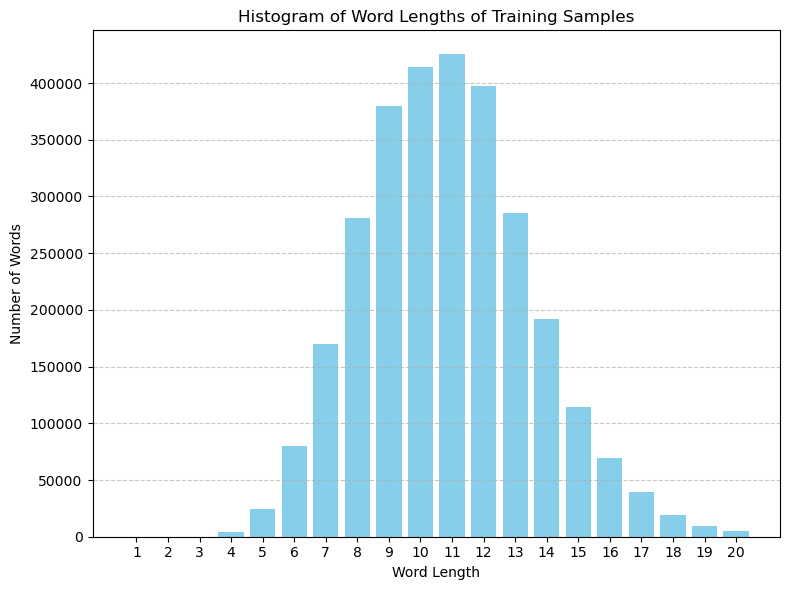

In [344]:
x = list(range(1, max_word_length+1))
plt.figure(figsize=(8, 6))
plt.bar(x, num_examples.reshape(-1), color='skyblue')
plt.xlabel("Word Length")
plt.ylabel("Number of Words")
plt.title("Histogram of Word Lengths of Training Samples")
plt.xticks(x)  # Ensure each word length shows up on the x-axis
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [345]:
input_path = "light_training_data.jsonl"
def read_data(input_path):
    training_data = []
    with open(input_path, "r") as f:
        for line in f:
            item = json.loads(line)
            training_data.append(item)
    return training_data

In [346]:
training_data = read_data(input_path)

In [347]:
random.shuffle(training_data)

In [348]:
training_data

[{'masked_word': 'decep_ious', 'guessed_letters': 'eipsdcuo', 'target': 't'},
 {'masked_word': '_ecti_ine____',
  'guessed_letters': 'eitnc',
  'target': 'lray'},
 {'masked_word': 'correl_ti_e_e__',
  'guessed_letters': 'ietlrco',
  'target': 'nsav'},
 {'masked_word': '_i_robe_ess', 'guessed_letters': 'eibsro', 'target': 'lmc'},
 {'masked_word': '_yro_e_e', 'guessed_letters': 'eroy', 'target': 'pnx'},
 {'masked_word': 'c_____pale', 'guessed_letters': 'eaplc', 'target': 'sro'},
 {'masked_word': '_u__e__l__e_in_',
  'guessed_letters': 'ienlu',
  'target': 'gsmwrfo'},
 {'masked_word': 'enno__e', 'guessed_letters': 'eno', 'target': 'lb'},
 {'masked_word': 'h__i_esses', 'guessed_letters': 'eish', 'target': 'nmo'},
 {'masked_word': 'ga__rophilu_',
  'guessed_letters': 'iagplruho',
  'target': 'ts'},
 {'masked_word': 'jeopo__i_e', 'guessed_letters': 'eipjo', 'target': 'zdr'},
 {'masked_word': 'u_di_me__ic', 'guessed_letters': 'eidmuc', 'target': 'tnra'},
 {'masked_word': '_ou__e_agg_essio_s',

c:\Users\yijin\anaconda3\envs\tf-gpu\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0, 0.5, 'number of training samples')

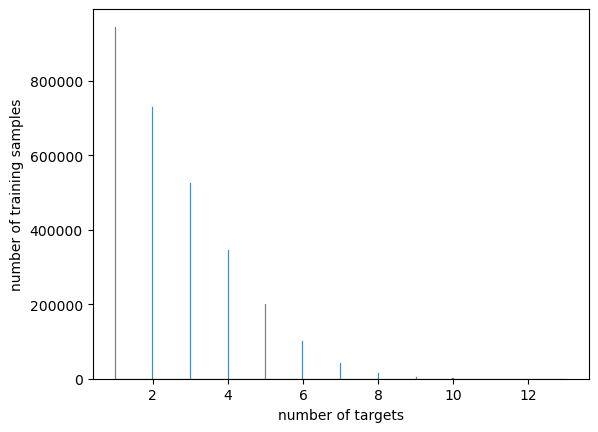

In [349]:
sns.histplot([len(training_data[i]['target']) for i in range(len(training_data))])
plt.xlabel('number of targets')
plt.ylabel('number of training samples')

In [350]:
# build vocabulary ordinal encoding
vocab = ['Pad'] + list(chr(i) for i in range(ord('a'), ord('z')+1)) + ['_']
char2idx = {ch: i for i, ch in enumerate(vocab)}

In [351]:
# encoding functions
def encode_input(masked_word, max_len=20):
    input_str = masked_word
    input_ids = [char2idx[c] for c in input_str]
    if len(input_ids) < max_len:
        input_ids += [char2idx['Pad']] * (max_len - len(input_ids))
    return input_ids

In [352]:
def encode_target(target):
    target_vec = [0] * 26  # only 'a' to 'z'
    for c in target:
        target_vec[ord(c) - ord('a')] = 1
    return target_vec

In [353]:
def encode(masked_word, guessed_letters, target, max_len=20):
    input_ids = encode_input(masked_word, max_len)
    guessed_vec = encode_target(guessed_letters)
    target_vec = encode_target(target)
    return input_ids, guessed_vec, target_vec

In [354]:
def encode_jsonl_data(input_path, output_path, max_len=20):
    encoded_data = []
    with open(input_path, "r") as f:
        for line in f:
            item = json.loads(line)
            masked_word = item["masked_word"]
            guessed_letters = item["guessed_letters"]
            target = item["target"]
            input_ids, guessed_vec, target_vec = encode(
                masked_word, guessed_letters, target, max_len
            )
            encoded_data.append({
                "input_ids": input_ids,
                "guessed_letters": guessed_vec,
                "target_vec": target_vec
            })
    # save encoded data
    with open(output_path, 'w') as f:
        # write each example as a separate line in the JSONL file
        for ex in encoded_data:
            f.write(json.dumps(ex) + "\n")
    
    print(f"Encoded {len(encoded_data)} samples.")
    return encoded_data


In [355]:
output_path = "light_encoded_training_data.jsonl"
training_data = encode_jsonl_data("light_training_data.jsonl", output_path, max_len=20)

Encoded 2910522 samples.


In [356]:
# read data from light_encoded_training_data
#input_path = "light_encoded_training_data.jsonl"
#training_data = read_data(input_path)

In [357]:
len(training_data)

2910522

In [358]:
training_data_input_ids = []
training_data_guessed_letters = []
training_data_targets = []
for i in range(len(training_data)): 
    training_data_input_ids.append(training_data[i]['input_ids'])
    training_data_guessed_letters.append(training_data[i]['guessed_letters'])
    training_data_targets.append(training_data[i]['target_vec'])

In [359]:
training_data_input_ids = np.array(training_data_input_ids)
training_data_guessed_letters =  np.array(training_data_guessed_letters)
training_data_targets = np.array(training_data_targets)

In [360]:
training_data_length = np.sum(training_data_input_ids != 0, axis=1)/20

In [361]:
print(training_data_input_ids.shape)
print(training_data_guessed_letters.shape)
print(training_data_length.shape)
print(training_data_targets.shape)

(2910522, 20)
(2910522, 26)
(2910522,)
(2910522, 26)


In [362]:
test_size = 0.01

In [363]:
# split training and testing dataset
training_data_input_ids,\
testing_data_input_ids,\
training_data_guessed_letters,\
testing_data_guessed_letters, \
training_data_length,\
testing_data_length,\
training_data_targets, \
testing_data_targets,\
= train_test_split(training_data_input_ids,\
                   training_data_guessed_letters,\
                   training_data_length,\
                   training_data_targets, \
                   test_size=test_size, 
                   shuffle=True,random_state=42)

# Build Model

In [ ]:
import os
import datetime
import pandas as pd
import tensorflow as tf
from keras.utils import Sequence
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Concatenate, Bidirectional, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.optimizers import Adam

In [ ]:
# set parameters
vocab_size = 28         # 0 to 27 (0 = Pad)
embedding_dim = 128
sequence_len = 20     # maximum sequence length
binary_vector_len = 26

# Input 1: masked word + guessed letters (sequence input)
seq_input = Input(shape=(sequence_len,), name="seq_input")
embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim, mask_zero=True)(seq_input)

lstm_output = Bidirectional(LSTM(512, return_sequences=True))(embedding)
lstm_output = Bidirectional(LSTM(256, return_sequences=True))(lstm_output)
lstm_output = Bidirectional(LSTM(128, return_sequences=False))(lstm_output)
# Input 2: binary guessed vector of 26
#binary_input = Input(shape=(binary_vector_len,), name="binary_input")
# Input 3: word length
length_input = Input(shape=(1,))
# Concatenate and output
combined = Concatenate()([lstm_output, length_input])
combined = Dense(64, activation='relu')(combined)
#combined = Dropout(0.3)(combined)
output = Dense(26, activation="sigmoid", name="output")(combined)  # sigmoid for multi-label
# Build model
model = Model(inputs=[seq_input, length_input], outputs=output)
# Create Adam optimizer with a custom learning rate
optimizer = Adam(learning_rate=3e-3)

model.compile(optimizer=optimizer, loss="binary_crossentropy")
model.summary()

NameError: name 'Input' is not defined

In [366]:
# Add EarlyStopping callback
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

In [367]:
log_dir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [368]:
class CustomDataGenerator(Sequence):
    def __init__(self, input_data_ids, input_data_length, target_data, batch_size, shuffle=True):
        self.input_data_ids = input_data_ids
        self.input_data_length = input_data_length
        self.target_data = target_data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = np.arange(len(self.input_data_ids))  # Indices to shuffle the data
        self.on_epoch_end()  # Shuffle data at the beginning

    def __len__(self):
        # Returns the number of batches per epoch
        return int(np.floor(len(self.input_data_ids) / self.batch_size))

    def __getitem__(self, index):
        # Generate one batch of data
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_input_ids = [self.input_data_ids[i] for i in batch_indices]
        batch_input_data_length = [self.input_data_length[i] for i in batch_indices]
        batch_target = [self.target_data[i] for i in batch_indices]

        return (np.array(batch_input_ids), np.array(batch_input_data_length)), np.array(batch_target)

    def on_epoch_end(self):
        # Shuffle data at the end of each epoch
        if self.shuffle:
            np.random.shuffle(self.indices)

In [369]:
# Set batch size and training parameters
batch_size = 1024

# Split data into training and validation sets
split_idx = int(0.9 * len(training_data_input_ids))  # 90% for training
train_input_ids = training_data_input_ids[:split_idx]
train_input_data_length = training_data_length[:split_idx]
train_target = training_data_targets[:split_idx]

val_input_ids = training_data_input_ids[split_idx:]
val_input_data_length = training_data_length[split_idx:]
val_target = training_data_targets[split_idx:]


In [370]:
len(train_input_ids)

2593274

In [371]:
# Create the training and validation generators
train_gen = CustomDataGenerator(train_input_ids, train_input_data_length, train_target, batch_size)
val_gen = CustomDataGenerator(val_input_ids, val_input_data_length, val_target, batch_size)

In [372]:
# Set batch size and training parameters
epochs = 50
# Train the model using the generators
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=epochs,
    callbacks=[early_stop, tensorboard_callback]
)

Epoch 1/50
2532/2532 [==============================] - 243s 89ms/step - loss: 0.2215 - val_loss: 0.1681
Epoch 2/50
2532/2532 [==============================] - 221s 87ms/step - loss: 0.1490 - val_loss: 0.1359
Epoch 3/50
2532/2532 [==============================] - 237s 94ms/step - loss: 0.1260 - val_loss: 0.1228
Epoch 4/50
2532/2532 [==============================] - 225s 89ms/step - loss: 0.1138 - val_loss: 0.1168
Epoch 5/50
2532/2532 [==============================] - 220s 87ms/step - loss: 0.1058 - val_loss: 0.1129
Epoch 6/50
2532/2532 [==============================] - 229s 91ms/step - loss: 0.0997 - val_loss: 0.1107
Epoch 7/50
2532/2532 [==============================] - 243s 96ms/step - loss: 0.0949 - val_loss: 0.1086
Epoch 8/50
2532/2532 [==============================] - 237s 94ms/step - loss: 0.0909 - val_loss: 0.1082
Epoch 9/50
2532/2532 [==============================] - 221s 87ms/step - loss: 0.0875 - val_loss: 0.1069
Epoch 10/50
2532/2532 [==============================] 

In [373]:
model.save("my_model_512_256_128_64.keras")

<Axes: >

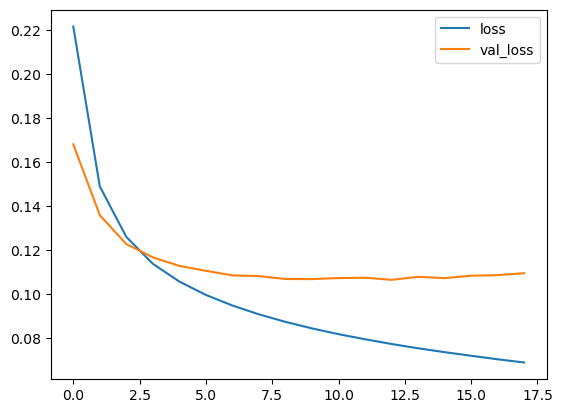

In [374]:
pd.DataFrame(history.history).plot()

In [375]:
testing_data_guessed_letters[0]

array([0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0])

In [376]:
testing_data_input_ids[0]

array([23, 27,  9, 20,  5, 27, 15, 15,  6,  5,  4,  0,  0,  0,  0,  0,  0,
        0,  0,  0])

In [377]:
# Predict a single sample
prediction = model.predict([
    testing_data_input_ids[0:1],          # shape (1, sequence_len)
    testing_data_length[0:1]
])


1/1 [==============================] - 6s 6s/step


In [378]:
prediction[0]

array([3.6958078e-04, 4.0509341e-05, 2.6870741e-06, 1.2247818e-07,
       1.4009504e-06, 7.7390914e-06, 3.5353958e-05, 9.9973756e-01,
       1.5391162e-10, 2.5780695e-05, 3.8362764e-06, 3.6929798e-04,
       1.2311376e-05, 2.0362216e-03, 1.6194685e-05, 4.3652130e-07,
       1.2662825e-06, 3.0682114e-01, 1.7801448e-03, 4.3286906e-07,
       1.3135198e-05, 8.4965279e-08, 1.7104501e-06, 2.3557719e-08,
       6.4567289e-06, 1.5976011e-07], dtype=float32)

In [379]:
testing_data_targets[0]

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0])

In [380]:
np.argsort(prediction[0])[::-1]

array([ 7, 17, 13, 18,  0, 11,  1,  6,  9, 14, 20, 12,  5, 24, 10,  2, 22,
        4, 16, 15, 19, 25,  3, 21, 23,  8], dtype=int64)

# Make predictions

In [381]:
import numpy as np
import string

def predict_next_letter(model, word, guessed_letters, length):
    """
    Predicts the next letter using the trained model, avoiding already guessed letters.
    """
    # Get model prediction (probabilities for each of the 26 letters)
    probs = model.predict([word, length], verbose=0)[0]  # shape (26,)
    
    # Convert guessed letters from binary to a boolean mask
    guessed_mask = guessed_letters[0].astype(bool)

    # Set the probabilities of already guessed letters to -1 to ignore them
    probs[guessed_mask] = -1
    
    # Pick the index (letter) with the highest remaining probability
    next_letter_index = np.argmax(probs)
    
    # Convert index back to character
    next_letter = string.ascii_lowercase[next_letter_index]
    
    return next_letter


In [382]:
word = testing_data_input_ids[3:4]
guessed_letters = testing_data_guessed_letters[3:4]
length = testing_data_length[3:4]
predict_next_letter(model, word, guessed_letters, length)

's'

In [383]:
testing_data_targets[0:1].shape

(1, 26)

# Model testing

In [416]:
k = 1000
test_size = min(k, testing_data_input_ids.shape[0])
prediction = model.predict([
    testing_data_input_ids[:test_size],          
    testing_data_length[:test_size]
])

32/32 [==============================] - 5s 19ms/step


In [417]:
top1_preds = np.argmax(prediction, axis=1)

c:\Users\yijin\anaconda3\envs\tf-gpu\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Count'>

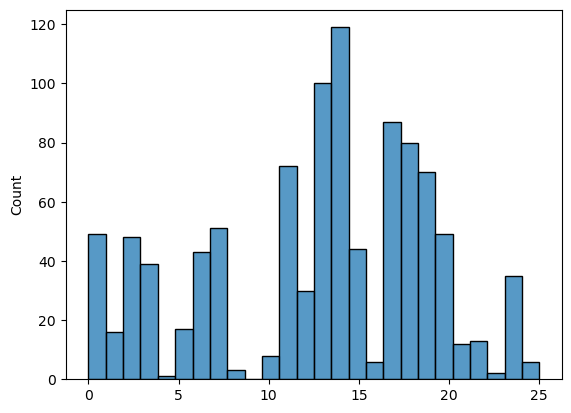

In [418]:
sns.histplot(top1_preds, bins=26)

In [419]:
accuracy = np.mean(testing_data_targets[np.arange(len(top1_preds)), top1_preds])

In [420]:
print('the accuracy on testing dataset is:', accuracy)

the accuracy on testing dataset is: 0.886


In [421]:
from tensorflow.keras.models import load_model

In [ ]:
# switch back to best performed model
model = load_model('my_model_512_256_128.keras')

# API Usage Examples

## To start a new game:
1. Make sure you have implemented your own "guess" method.
2. Use the access_token that we sent you to create your HangmanAPI object. 
3. Start a game by calling "start_game" method.
4. If you wish to test your function without being recorded, set "practice" parameter to 1.
5. Note: You have a rate limit of 20 new games per minute. DO NOT start more than 20 new games within one minute.

In [425]:
api = HangmanAPI(access_token="a10a70f36b5e444235e2e3527bae82", model = model, word_list=word_list, max_len=20, timeout=2000)

## Playing practice games:
You can use the command below to play up to 100,000 practice games.

In [428]:
api.start_game(practice=1,verbose=True)
[total_practice_runs,total_recorded_runs,total_recorded_successes,total_practice_successes] = api.my_status() # Get my game stats: (# of tries, # of wins)
practice_success_rate = total_practice_successes / total_practice_runs
print('run %d practice games out of an allotted 100,000. practice success rate so far = %.3f' % (total_practice_runs, practice_success_rate))

Successfully start a new game! Game ID: b041a4591a6a. # of tries remaining: 6. Word: _ _ _ _ _ _ _ _ _ _ _ _ _ .
Early Stage of the game
Guessing letter: e
Sever response: {'game_id': 'b041a4591a6a', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ _ _ _ _ _ e _ _ e _ _ '}
Early Stage of the game
Guessing letter: i
Sever response: {'game_id': 'b041a4591a6a', 'status': 'ongoing', 'tries_remains': 6, 'word': 'i _ _ _ _ i _ e _ _ e _ _ '}
Early Stage of the game
Guessing letter: n
Sever response: {'game_id': 'b041a4591a6a', 'status': 'ongoing', 'tries_remains': 6, 'word': 'i n _ _ _ i n e _ n e _ _ '}
Mid Stage of the game
Guessing letter: t
Sever response: {'game_id': 'b041a4591a6a', 'status': 'ongoing', 'tries_remains': 5, 'word': 'i n _ _ _ i n e _ n e _ _ '}
Mid Stage of the game
Guessing letter: s
Sever response: {'game_id': 'b041a4591a6a', 'status': 'ongoing', 'tries_remains': 5, 'word': 'i n _ _ _ i n e _ n e s s '}
Mid Stage of the game
Guessing letter: a
Sever response: {'ga

In [429]:
api.word_len

[5, 6, 13]

In [430]:
api.results

[0, 0, 1]

In [431]:
result = []
for i in range(500):
    print('Playing ', i, ' th game')
    [_,_,_,total_practice_successes_old] = api.my_status()
    api.start_game(practice=1,verbose=True)
    [_,_,_,total_practice_successes_new] = api.my_status() # Get my game stats: (# of tries, # of wins)
    result.append(total_practice_successes_new - total_practice_successes_old)
    print('updated succesful rate: ', np.mean(result))
    time.sleep(0.5)

Playing  0  th game
Successfully start a new game! Game ID: 7beb25f85f8d. # of tries remaining: 6. Word: _ _ _ _ _ .
Early Stage of the game
Guessing letter: a
Sever response: {'game_id': '7beb25f85f8d', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ a _ _ _ '}
Early Stage of the game
Guessing letter: e
Sever response: {'game_id': '7beb25f85f8d', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ a _ _ _ '}
Early Stage of the game
Guessing letter: s
Sever response: {'game_id': '7beb25f85f8d', 'status': 'ongoing', 'tries_remains': 5, 'word': 's a _ _ _ '}
Early Stage of the game
Guessing letter: r
Sever response: {'game_id': '7beb25f85f8d', 'status': 'ongoing', 'tries_remains': 5, 'word': 's a _ _ r '}
Mid Stage of the game
Guessing letter: t
Sever response: {'game_id': '7beb25f85f8d', 'status': 'ongoing', 'tries_remains': 4, 'word': 's a _ _ r '}
Mid Stage of the game
Guessing letter: o
Sever response: {'game_id': '7beb25f85f8d', 'status': 'ongoing', 'tries_remains': 4, 'word': '

In [433]:
api.results

[0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,


In [432]:
api.word_len

[5,
 6,
 13,
 5,
 7,
 12,
 9,
 12,
 6,
 11,
 7,
 6,
 8,
 6,
 6,
 9,
 12,
 7,
 6,
 11,
 7,
 10,
 13,
 10,
 7,
 11,
 8,
 5,
 10,
 6,
 10,
 7,
 12,
 10,
 14,
 11,
 9,
 6,
 15,
 7,
 16,
 4,
 8,
 8,
 8,
 13,
 13,
 10,
 8,
 8,
 9,
 9,
 10,
 14,
 2,
 9,
 6,
 8,
 8,
 12,
 7,
 12,
 12,
 14,
 7,
 7,
 5,
 10,
 13,
 9,
 11,
 10,
 12,
 7,
 8,
 8,
 10,
 10,
 12,
 13,
 10,
 13,
 10,
 9,
 10,
 4,
 12,
 8,
 8,
 7,
 11,
 11,
 10,
 6,
 11,
 7,
 7,
 12,
 7,
 9,
 10,
 11,
 10,
 17,
 9,
 10,
 9,
 13,
 5,
 6,
 14,
 11,
 13,
 10,
 11,
 12,
 8,
 9,
 4,
 6,
 12,
 8,
 6,
 9,
 9,
 13,
 6,
 8,
 9,
 10,
 13,
 13,
 8,
 10,
 12,
 10,
 12,
 9,
 12,
 5,
 9,
 8,
 9,
 11,
 10,
 6,
 15,
 12,
 9,
 11,
 6,
 4,
 12,
 9,
 9,
 6,
 7,
 13,
 6,
 11,
 7,
 7,
 14,
 8,
 5,
 13,
 13,
 11,
 7,
 8,
 7,
 4,
 10,
 9,
 6,
 13,
 4,
 10,
 8,
 10,
 15,
 7,
 6,
 13,
 13,
 7,
 9,
 8,
 14,
 7,
 9,
 12,
 7,
 12,
 10,
 14,
 13,
 11,
 13,
 7,
 12,
 16,
 9,
 9,
 9,
 13,
 6,
 6,
 9,
 10,
 12,
 11,
 11,
 5,
 12,
 7,
 6,
 10,
 9,
 10,
 8,
 10,
 11,
 

c:\Users\yijin\anaconda3\envs\tf-gpu\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Count'>

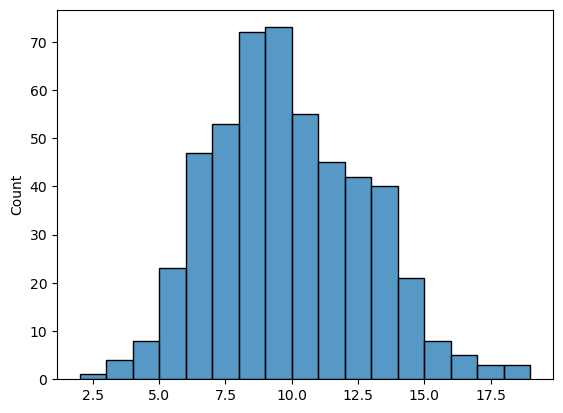

In [436]:
sns.histplot(api.word_len)

In [464]:
successful_rate = [0] * max(api.word_len)
count = [0] * max(api.word_len)
for i in range(len(api.word_len)):
    successful_rate[api.word_len[i] - 1] += api.results[i]
    count[api.word_len[i] - 1] += 1

In [465]:
successful_rate = np.array(successful_rate)/np.array(count)

C:\Users\yijin\AppData\Local\Temp\ipykernel_38112\3278980797.py:1: RuntimeWarning: invalid value encountered in divide
  successful_rate = np.array(successful_rate)/np.array(count)


In [466]:
successful_rate

array([       nan, 0.        , 0.        , 0.07692308, 0.17105263,
       0.30952381, 0.33928571, 0.45641026, 0.55825243, 0.71122995,
       0.83544304, 0.856     , 0.8556701 , 0.96      , 1.        ,
       0.875     , 1.        , 1.        , 1.        , 0.        ])

c:\Users\yijin\anaconda3\envs\tf-gpu\lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


Text(0.5, 1.0, 'successful rate of the algorithm across all word length')

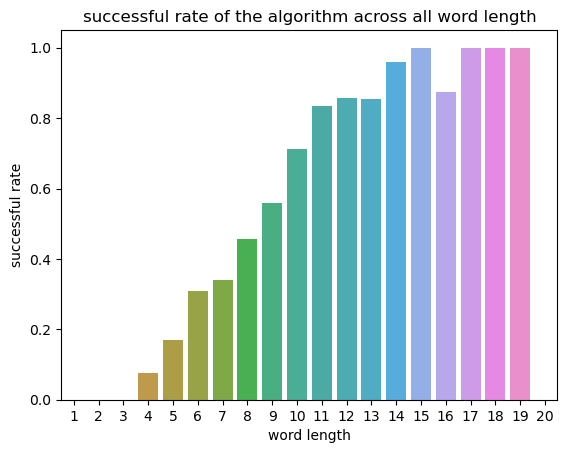

In [467]:
sns.barplot(x = [i for i in range(1, max(api.word_len)+1)], y = successful_rate)
plt.xlabel('word length')
plt.ylabel('successful rate')
plt.title('successful rate of the algorithm across all word length')

In [455]:
# result with mid stage (if len_dict > 200 and tries_remains > 2): 0.588 (200 games, first time)
# result with mid stage (if len_dict > 200 and tries_remains > 2): 0.5 (200 games, second time)
# result with mid stage (if len_dict > 100): 0.505 (200 games)
# result with no mid stage: 0.52 (200 games)

In [456]:
np.mean(result)

0.574

## Playing recorded games:
Please finalize your code prior to running the cell below. Once this code executes once successfully your submission will be finalized. Our system will not allow you to rerun any additional games.

Please note that it is expected that after you successfully run this block of code that subsequent runs will result in the error message "Your account has been deactivated".

Once you've run this section of the code your submission is complete. Please send us your source code via email.

In [461]:
for i in range(1000):
    print('Playing ', i, ' th game')
    # Uncomment the following line to execute your final runs. Do not do this until you are satisfied with your submission
    api.start_game(practice=0,verbose=True)
    [total_practice_runs,total_recorded_runs,total_recorded_successes,total_practice_successes] = api.my_status() # Get my game stats: (# of tries, # of wins)
    recorded_success_rate = total_recorded_successes / total_recorded_runs
    if recorded_success_rate < 0.58:
        break
    print('run %d recorded games out of an allotted 1000. recored success rate so far = %.3f' % (total_recorded_runs, recorded_success_rate))
    # DO NOT REMOVE as otherwise the server may lock you out for too high frequency of requests
    time.sleep(0.5)

Playing  0  th game


HangmanAPIError: {'error': 'Your account has been deactivated!'}

## To check your game statistics
1. Simply use "my_status" method.
2. Returns your total number of games, and number of wins.

In [462]:
[total_practice_runs,total_recorded_runs,total_recorded_successes,total_practice_successes] = api.my_status() # Get my game stats: (# of tries, # of wins)
success_rate = total_recorded_successes/total_recorded_runs
print('overall success rate = %.3f' % success_rate)

overall success rate = 0.589


# Stragety

### Overview
My strategy is to divide each Hangman game into three stages, early stage, mid stage, and late stage. The method of guessing the next letter gradually shifts from statistical frequency analysis to LSTM-based pattern recognition as more information becomes available.

### Stage Definitions and Strategies

**Early Stage (0-1 letters known)**
The game begins in the early stage when fewer than two letters are revealed. At this point, word patterns are unclear and insufficient for meaningful pattern recognition. Perphas the optimal strategy is to rely on pure statistical frequency analysis:
- First letter: Choose the letter with highest frequency in the dictionary given the word length.
- Second letter: Choose based on highest frequency considering the first letter, word length, and previous wrong attempts.

**Mid Stage (2+ letters known, abundant candidate words)**
The game moves to mid stage when at least two letters are known. Pure frequency-based guessing could becomes suboptimal in this stage because it ignores letter positioning. At this stage, we employ a hybrid approach:
- Combine statistical frequency predictions with LSTM model outputs.

**Late Stage (Sparse candidate words or critical decisions)**
The late stage of the game is triggered when either:
- Fewer than 200 words in the dictionary satisfy current constraints, i.e. word length, correct attempts, and wrong attemps. Or
- only 3 attempts remain.

The word candidate pool becomes spars. Hence it is unreliable, in particular the testing words is disjoiint with the words dictionary. However, at this stage, the word patterns become highly informative (e.g., "a _ _ l e"). At this stage, we rely exclusively on the LSTM model for pattern completion.

### LSTM Training Strategy
Following our stragety for playing the game, the LSTM model is trained to be good at pattern recognition at late game rather than frequency guessing at early game:
- **Training data selection**: All samples contain at least two revealed letters.
- **Selective sampling**: Higher proportion of training examples with more letters revealed.

### Future Work
Our analysis reveals a clear relationship between word length and strategy performance. Our approach demonstrates significantly higher success rates for longer words, achieving approximately 60% success for 9-letter words, over 70% for 10-letter words, and exceeding 80% for words with 11+ letters. However, performance degrades substantially for shorter words, dropping below 40% for words with 7 or fewer letters.
This performance pattern suggests that our current strategy is optimized for scenarios where sufficient context information emerges during gameplay. Longer words provide more information for pattern recognition as the game progresses. However, shorter words offer limited information even in late stages.

Hence, the future work for improving the successful rate of the stragety is to focus on the shorter words. One possible solution is to train a new LSTM model focus solely on words with length smaller or equal to 8, potentially with different architectural choices optimized for limited context information scenarios. It is also possible to adaptively transit the stage of the game based on the word length: since the LSTM model appears to perform worse for shorter words, we might want to rely more on the statistical frequency analysis if the word length is short.